In [1]:
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import numbers
from ipyleaflet import Map, GeoData, basemaps, WidgetControl, SearchControl
from ipywidgets import HTML
import geopandas as gpd

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In this notebook we will show you how to use the trained RHEM Emulator to estimate the runoff, soil loss and sediment yield through the following steps:

1- Load the trained Emulator and required files

2- Introduce the structure of a RHEM scenario

3- Define your own scenario

4- Predict the outputs by your own scenario

5- Define a batch of scenarios and run the Emulator in the batch mode

### Before starting the tutorial: 

Ensure that you have successfully acquired the Files.zip file from [this link](https://github.com/saeedimd/RHEM-ML/releases/latest) and extract its contents within the identical directory as this notebook.

### 1- Load the trained Emulator and required files
By runnig the cell below you will be able to load the pre-trained RHEM Emulator for further use.

The weighted_binary_crossentropy() function was used for the runoff and soil loss binary classifiers (to train the part of the model that allows for zero-valued outputs and ensures that the soil loss is zero if there is no runoff). See section 2.7 for of the paper.

In [3]:
def weighted_binary_crossentropy(zero_weight=1.0, one_weight=1.0):

    def weighted_binary_crossentropy(y_true, y_pred):
        y_true = tf.cast(y_true, dtype='float64')
        y_pred = tf.cast(y_pred, dtype='float64')
        b_ce = K.binary_crossentropy(y_true, y_pred)
        # weighted calc
        weight_vector = y_true * one_weight + (1 - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce
        return K.mean(weighted_b_ce)
emulator = tf.keras.models.load_model('Files/Trained_Models/emulator.h5', 
                                      custom_objects={ 'weighted_binary_crossentropy': weighted_binary_crossentropy()})

##### To load the version of the Emulator that is fine-tuned with the NRI dataset uncomment the lines below

# emulator =  tf.keras.models.load_model('Trained_Emulator/emulator_fineTuned.h5', 
#                                       custom_objects={ 'weighted_binary_crossentropy': weighted_binary_crossentropy()})

The output of the cell bellow shows the number of Trainable and non-Trainable parameters of the Emulator and also its schematic architecture. See section 2.2 of the paper  

Total Trainable Parameters: 678,277
Total non-Trainable Parameters: 2,592
Total Parameters: 680,869


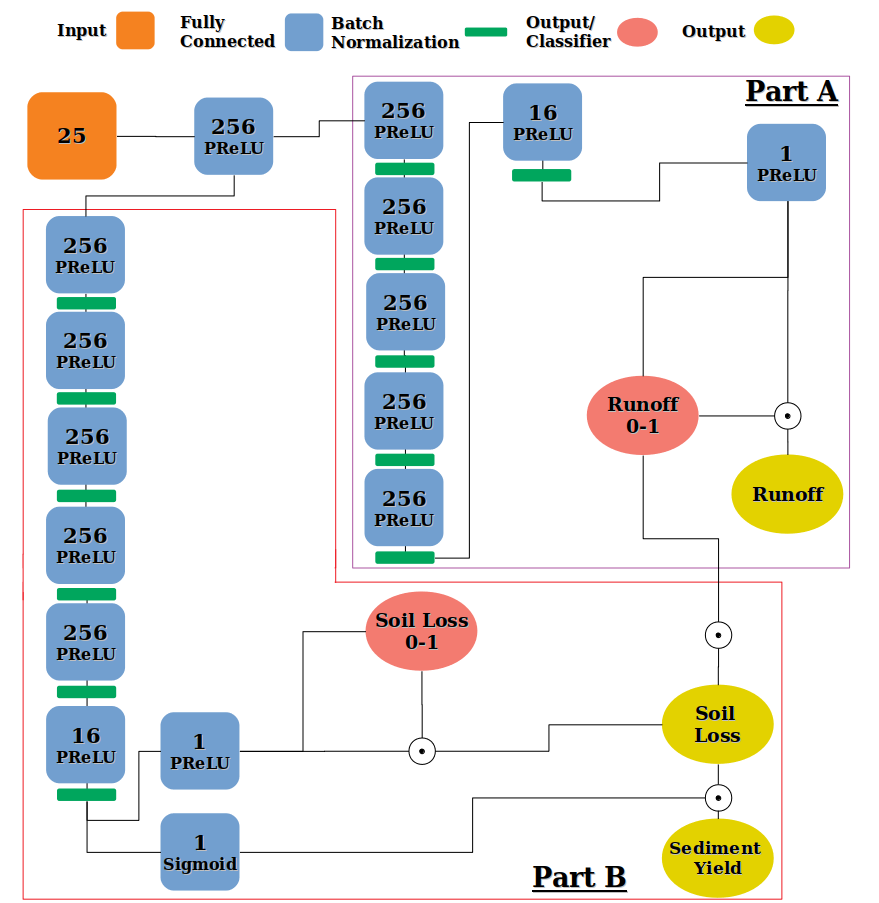

In [4]:
trainableParams = np.sum([np.prod(v.get_shape()) for v in emulator.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in emulator.non_trainable_weights])
totalParams = trainableParams + nonTrainableParams
 
print('Total Trainable Parameters:', f'{trainableParams:,}')
print('Total non-Trainable Parameters:', f'{nonTrainableParams:,}')
print('Total Parameters:', f'{totalParams:,}')

from IPython.display import Image
Image(filename='emulator.png', width=500, height=300) 

Here we load the file that is needed to normalize the input values of the Emulator. See section 2.7 of the paper

In [5]:
with open('Files/Normalizers/minmaxt_x.pkl', 'rb') as file:
    minmaxt_x = pickle.load(file)    
with open('Files/Normalizers/minmaxt_y_runoff.pkl', 'rb') as file:
    minmaxt_y_runoff = pickle.load(file)
with open('Files/Normalizers/minmaxt_y_erosion.pkl', 'rb') as file:
    minmaxt_y_erosion = pickle.load(file)

### 2- A RHEM Scenario 
A RHEM scenario is a dictionary that contains the user inputs to the RHEM (See the left coulmn of Table 1 of the paper). Display an example of a RHME scenario by running the cell below

In [6]:
scenario = {'Station_ID': 'hi511303',
            'soilTexture': 'clay loam',
            'slope': 42.07,
            'slopeShape': 'Convex',
            'Litter': 15.80,
            'BiologicalCrusts': 12.61,
            'Basal': 10.28,
            'Rock': 2.76,
            'Forbs': 0.05,
            'BunchGrass': 0.04,
            'Shrubs': 17.13,
            'SodGrass': 0.007}

scenario

{'Station_ID': 'hi511303',
 'soilTexture': 'clay loam',
 'slope': 42.07,
 'slopeShape': 'Convex',
 'Litter': 15.8,
 'BiologicalCrusts': 12.61,
 'Basal': 10.28,
 'Rock': 2.76,
 'Forbs': 0.05,
 'BunchGrass': 0.04,
 'Shrubs': 17.13,
 'SodGrass': 0.007}

A RHEM scenario must be converted to a format that can be used as an Emulator input. An Emulator input is a numpy array of shape (1, 25). 25 is the number of attributes of an Emulator input which are:

[prcp, dur, tp, ip, SL1, SL2, G, DIST, POR, SMAX, FRACT1, FRACT2, FRACT3, FRACT4, FRACT5, Litter, BiologicalCrusts, Basal, Rock, totalGround, Forbs, BunchGrass, Shrubs, SodGrass, totalFoliar] (See Table 2 of the paper). 

But, first let's see how can we define the items of the scenario:

### 3- Define a RHEM Scenario
To define a RHEM scenario, the following items should be specified:
- CLIGEN Station ID
- Slope and Slope Shape
- Soil Texture
- Ground Covers %: Litter, Biological Crusts, Basal and, Rock
- Foliar Covers %: Forbs, Bunch Grass, Shrubs, Sod Grass

- CLIGEN station ID: 

We have two options to get a CLIGEN station ID:

1- Using an interactive map:
Run the cell bellow to display the map. The map shows the blue dots which are the locations of the CLIGEN station in the U.S. Click on any point to select it. The ID of the selected station is saved into 'selected_ID' for further usage. On the upper right corner of the map the current selected station is shown. The map can be explored manually to find a desired location. Also, there is a search tool to find and zoom into the desired location

In [8]:
cligen = gpd.read_file('Files/Parameter_Files/CLIGEN_points.shp')
center = [38.3765, -100.6029]
zoom = 4

cligenMap = Map(basemap=basemaps.Esri.WorldTopoMap, center=center, zoom=zoom, scroll_wheel_zoom=True)

cligen = GeoData(geo_dataframe = cligen,
                 style={'color': 'black', 'radius':4, 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                point_style={'radius': 5, 'color': 'red', 'fillOpacity': 0.8, 'fillColor': 'blue', 'weight': 3})


cligenMap.add_layer(cligen)

html = HTML('''Click on a CLIGEN Station''')
html.layout.margin = '0px 20px 20px 20px'
control = WidgetControl(widget=html, position='topright')
cligenMap.add_control(control)
def click_handler(**kwargs):
    global selected_ID
    selected_ID = kwargs['properties']['ID']
    html.value = '''
     <h5><b>Selected Station: {}</b></h5>
     <h5>prcp: {} </h5> 
     <h5>dur: {} </h5>
     <h5>tp: {} </h5>
     <h5>ip: {} </h5>
      '''.format(kwargs['properties']['ID'],
                np.round(float(kwargs['properties']['prcp']), 2),
                np.round(float(kwargs['properties']['dur']), 2),
                np.round(float(kwargs['properties']['tp']), 2),
                np.round(float(kwargs['properties']['ip']), 2))
cligen.on_click(click_handler)

cligenMap.add_control(SearchControl(
  position="topleft",
  url='https://nominatim.openstreetmap.org/search?format=json&q={s}',
  zoom=9
))

cligenMap

Map(center=[38.3765, -100.6029], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

Run the cell below to verify that the ID of the selected station is assigned to the 'selected_ID' variable

In [9]:
selected_ID

'mn218679'

2- From  prcp, dur, tp, ip values: Another way to assign a CLIGEN station ID to 'selected_ID' is to specify the desired rainfall volume in mm (prcp), Rainfall Duration in hours (dur) and Rainfall Peak intensity (tp, ip) values and retrieve the station which has the closets values to the specified list. The cligen_ID_retrieve() function gets 4 values (prcp, dur, tp, ip) and returns the station ID.

(The 'cligenTab' table contains the ID and prcp, dur, tp, ip of all available CLIGEN stations in the U.S.)

In [10]:
cligenTab = pd.read_csv('Files/Parameter_Files/cligen.csv')

scaler = MinMaxScaler()
cligenPrcp_normal = cligenTab.iloc[:,:-1]
scaler.fit(cligenPrcp_normal)
cligenPrcp_normal = scaler.transform(cligenPrcp_normal)
cligenPrcp_normal = pd.DataFrame(cligenPrcp_normal, columns=['prcp', 'dur', 'tp', 'ip'])

def cligen_ID_retrieve(prcp, dur, tp, ip):
    
    cligenList = [prcp, dur, tp, ip]
    numCheck = [isinstance(i, numbers.Number) for i in cligenList]
    if not all(numCheck):
        raise Exception('prcp, dur, tp, ip must be numbers')

    if not all(np.array(cligenList) >= 0):
        raise Exception('prcp, dur, tp, ip must be greater than 0')

    parameters_norm = scaler.transform(np.expand_dims(cligenList, axis=0))
    diffs = []
    diffs.append(cligenPrcp_normal.apply(lambda x: np.sum(np.abs(parameters_norm - x.values[:])), axis=1))
    station = cligenTab.iloc[np.argmin(np.array(diffs)), -1]
    return station
            

    
print('The closest station is:')          
selected_ID = cligen_ID_retrieve(prcp=1,dur=2,tp=3,ip=4)
print(selected_ID)

The closest station is:
wy483100


- Slope and Slope Shape

Please run the cell below and sepecify Slope% and Slope Shape. Slope must be a value between 0-100 and Slope Shape must be one of uniform, convex, concave.

In [11]:
slope = input('Enter the Slope%:')
slope_shape = input('Enter the Slope Shape:')

Enter the Slope%:46
Enter the Slope Shape:concave


- Soil Texture

Please run the cell below and specify the Soil Texture from the following list: 
- sand
- loamy sand
- sandy loam
- loam
- silt loam
- silt
- sandy clay loam
- clay loam
- silty clay loam
- sandy clay
- silty clay
- clay

In [12]:
soilTexture = input('Enter the Soil Texture:')

Enter the Soil Texture:clay


- Ground Covers%

Please run the cell below and specify Litter Cover%, BiologicalCrusts Cover%, Basal Cover%, Rock Cover%. The numbers must be non negative which sum up to a value between 0 and 100 inclusive

In [13]:
Litter = input('Enter the Litter Cover %:')
BiologicalCrusts = input('Enter the BiologicalCrusts Cover %:')
Basal = input('Enter the Basal Cover %:')
Rock = input('Enter the Rock Cover %:')

Enter the Litter Cover %:61
Enter the BiologicalCrusts Cover %:2
Enter the Basal Cover %:12
Enter the Rock Cover %:0


- Foliar Covers%

Please run the cell below and specify Forbs Cover%, Bunch Grass Cover%, Shrubs Cover%, Sod Grass Cover%. The numbers must be non negative which sum up to a value between 0 and 100 inclusive

In [14]:
Forbs = input('Enter the Forbs Cover %:')
BunchGrass = input('Enter the Bunch Grass Cover %:')
Shrubs = input('Enter the Shrubs Cover %:')
SodGrass = input('Enter the Sod Grass Cover %:')

Enter the Forbs Cover %:33
Enter the Bunch Grass Cover %:9
Enter the Shrubs Cover %:40
Enter the Sod Grass Cover %:0.6


##### After defining the required items, run the cell below to make the dictionary of the RHEM scenario

In [15]:
scenario = {'station_ID': selected_ID, 'slope': float(slope), 'slope_shape': slope_shape, 
              'soilTexture': soilTexture, 'Litter': float(Litter), 'BiologicalCrusts': float(BiologicalCrusts),
              'Basal': float(Basal), 'Rock': float(Rock), 'Forbs': float(Forbs), 'BunchGrass': float(BunchGrass),
              'Shrubs': float(Shrubs), 'SodGrass': float(SodGrass)}
scenario

{'station_ID': 'wy483100',
 'slope': 46.0,
 'slope_shape': 'concave',
 'soilTexture': 'clay',
 'Litter': 61.0,
 'BiologicalCrusts': 2.0,
 'Basal': 12.0,
 'Rock': 0.0,
 'Forbs': 33.0,
 'BunchGrass': 9.0,
 'Shrubs': 40.0,
 'SodGrass': 0.6}

##### It is time to convert the scenario to the format of the Emulator Input array

The create_input() function makes sure that the items above were correctly specified using the following functions:

- The get_cligen_pars() function checks the specified station_ID value. If it is legit, the prcp, dur, tp and ip of the station are returned.
- The slope_prop() function checks the specified Slope% and Slope Shape values. If they are legit, the  SL1 and SL2 input variables of the Emulator are returned.
- The soil_prop_from_texture() checks the specified Soil Texture. If it is correctly defined, the G, DIST, POR, SMAX, FRAC1, FRAC2, FRAC3, FRAC4, FRAC5 of the soil texture are returned.
- The check_the_ground_covers() function makes sure that the Litter, BiologicalCrusts, Basal, Rock covers are correctly specified. Then it returns the following Emulator input variables: Litter, BiologicalCrusts, Basal, Rock and totalGround.
- The check_the_foliar_covers() function makes sure that the Forbs, BunchGrass, Shrubs, SodGrass covers are correctly specified. Then it returns the following Emulator input variables: Forbs, BunchGrass, Shrubs, SodGrass, totalFoliar.

If there is any problem in the specified items, the create_input() function prints the error and guids you how to resolve it.

If everything is correct, the function returns the scenario.

Run the cell below to load the functions

In [16]:
cligenTab = pd.read_csv('Files/Parameter_Files/cligen.csv')
def get_cligen_pars(station_ID):
    
    if type(station_ID) != str:
        raise Exception('The stationID must be a string')

    if station_ID not in cligenTab['ID'].values.tolist():
        raise Exception('stationID is not among the available CLIGEN stations')

    cligenPar = cligenTab[cligenTab['ID'] == station_ID].iloc[0,:-1].values
    return cligenPar[0], cligenPar[1], cligenPar[2], cligenPar[3]


def slope_prop(slope, slope_shape):
    
    if not isinstance(slope, numbers.Number):
        raise Exception('The slope must be a number between 0 and 100 inclusive')
    if slope > 100 or slope < 0:
        raise Exception('The slope must be between 0 and 100 inclusive')
        
    if type(slope_shape) != str:
        raise Exception('The slope shape must be one of the following: uniform, convex, concave')
    
    slope_shape = slope_shape.lower()
    if slope_shape not in ['uniform', 'convex', 'concave']:
        raise Exception('The slope shape must be one of the following: uniform, convex, concave')
        
    if slope_shape == 'uniform':
        SL1 = slope/100
        SL2 = slope/100

    elif slope_shape == 'convex':
        SL1 = 0.001
        SL2 = slope/100

    else:
        SL1 = slope/100
        SL2 = 0.001
    
    return SL1, SL2


soil = pd.read_csv('Files/Parameter_Files/Soil_Hydraulic_Properties.csv')
def soil_prop_from_texture(soilTexture):
    soilTexture = soilTexture.lower()
    if not soilTexture in soil.Soil_Texture_Class.values.tolist():
        raise Exception('The Selected soil texture is unknown')
    else:
        soilParameters = soil[soil['Soil_Texture_Class'] == soilTexture].values[0,1:].tolist()
        return soilParameters[0], soilParameters[1], soilParameters[2], soilParameters[3], soilParameters[4], soilParameters[5], soilParameters[6], soilParameters[7], soilParameters[8]

    
def check_the_ground_covers(Litter, BiologicalCrusts, Basal, Rock):
    
    coverList = [Litter, BiologicalCrusts, Basal, Rock]
        
    numCheck = [isinstance(i, numbers.Number) for i in coverList]
    if not all(numCheck):
        raise Exception('All covers must be numeric')
        
    if not all(np.array(coverList) >= 0) or not all(np.array(coverList) <= 100):
        raise Exception('All covers must be between 0 and 100 inclusive')
        
    if np.sum(np.array(coverList)) > 100:
        raise Exception('The covers must sum up to a value less than or equal to 100')

    return Litter, BiologicalCrusts, Basal, Rock, np.sum(np.array(coverList))


def check_the_foliar_covers(Forbs, BunchGrass, Shrubs, SodGrass):
    
    coverList = [Forbs, BunchGrass, Shrubs, SodGrass]
        
    numCheck = [isinstance(i, numbers.Number) for i in coverList]
    if not all(numCheck):
        raise Exception('All covers must be numeric')
        
    if not all(np.array(coverList) >= 0) or not all(np.array(coverList) <= 100):
        raise Exception('All covers must be between 0 and 100 inclusive')
        
    if np.sum(np.array(coverList)) > 100:
        raise Exception('The covers must sum up to a value less than or equal to 100')

    return Forbs, BunchGrass, Shrubs, SodGrass, np.sum(np.array(coverList))


def create_input(scenario):
    
    prcp, dur, tp, ip = get_cligen_pars(scenario['station_ID'])
    
    SL1, SL2 = slope_prop(scenario['slope'], scenario['slope_shape'])
    
    G, DIST, POR, SMAX, FRACT1, FRACT2, FRACT3, FRACT4, FRACT5 = soil_prop_from_texture(scenario['soilTexture'])
    
    Litter, BiologicalCrusts, Basal, Rock, totalGround = check_the_ground_covers(scenario['Litter'],
                                                                                 scenario['BiologicalCrusts'],
                                                                                 scenario['Basal'], 
                                                                                 scenario['Rock'])
    
    Forbs, BunchGrass, Shrubs, SodGrass, totalFoliar = check_the_foliar_covers(scenario['Forbs'], 
                                                                               scenario['BunchGrass'], 
                                                                               scenario['Shrubs'], 
                                                                               scenario['SodGrass'])
    
    return np.expand_dims([prcp, dur, tp, ip, SL1, SL2, G, DIST, POR, SMAX, FRACT1, FRACT2, FRACT3, 
            FRACT4, FRACT5, Litter, BiologicalCrusts, Basal, Rock, totalGround, Forbs, 
            BunchGrass, Shrubs, SodGrass, totalFoliar], axis=0)


In [17]:
Emulator_input = create_input(scenario)

display(pd.DataFrame(Emulator_input, columns=['prcp', 'dur', 'tp', 'ip','SL1', 'SL2', 'G', 'DIST', 'POR', 'SMAX',
                   'FRACT1', 'FRACT2', 'FRACT3', 'FRACT4', 'FRACT5','Litter', 'BiologicalCrusts', 'Basal',
                   'Rock', 'totalGround', 'Forbs', 'BunchGrass', 'Shrubs', 'SodGrass','totalFoliar']))

print('The shape of the Emulator input is:', Emulator_input.shape)
Emulator_input

,prcp,dur,tp,ip,SL1,SL2,G,DIST,POR,SMAX,...,Litter,BiologicalCrusts,Basal,Rock,totalGround,Forbs,BunchGrass,Shrubs,SodGrass,totalFoliar
0,4.110036,2.251373,0.253325,4.014259,0.46,0.001,400.0,0.16,0.4724,0.81,...,61.0,2.0,12.0,0.0,75.0,33.0,9.0,40.0,0.6,82.6


The shape of the Emulator input is: (1, 25)


array([[4.11003572e+00, 2.25137331e+00, 2.53324614e-01, 4.01425927e+00,
        4.60000000e-01, 1.00000000e-03, 4.00000000e+02, 1.60000000e-01,
        4.72400000e-01, 8.10000000e-01, 1.24700000e-01, 1.00000000e-04,
        2.56700000e-01, 6.05700000e-01, 1.28000000e-02, 6.10000000e+01,
        2.00000000e+00, 1.20000000e+01, 0.00000000e+00, 7.50000000e+01,
        3.30000000e+01, 9.00000000e+00, 4.00000000e+01, 6.00000000e-01,
        8.26000000e+01]])

### 4- Run the Emulator for the scenario
The RHEM_Emulator() function gets the Emulator input and returns the Emulator estimation of the annual average runoff, soil loss and sediment yield over 300 years.


In [18]:
def RHEM_Emulator(scenario):
    
    X = scenario.copy()
    X[:,15:] = X[:,15:]/100
    X[:,[0,1,3,6]] = minmaxt_x.transform(X[:,[0,1,3,6]])
    
    predicted = emulator.predict(tf.convert_to_tensor(X))
    predicted = np.squeeze(np.array(predicted), axis=2).T

    predicted[:,2:3] = minmaxt_y_runoff.inverse_transform(predicted[:,2:3])
    predicted[:,3:4] = minmaxt_y_erosion.inverse_transform(predicted[:,3:4])
    predicted[:,4:] = minmaxt_y_erosion.inverse_transform(predicted[:,4:])

    predicted[:,2:3] = np.exp(predicted[:,2:3])
    predicted[:,3:] = np.exp(predicted[:,3:])

    predicted[:, 2] = predicted[:, 2] * predicted[:, 0]
    predicted[:, 3] = predicted[:, 3] * predicted[:, 1]
    predicted[:, 4] = predicted[:, 4] * predicted[:, 1]
    
    np.set_printoptions(suppress=True)
    print('Average Runoff(mm/year):')
    print(np.round(predicted[:, 2], 3))
    print('')
    print('Average Soil Loss(Mg/ha/year):')
    print(np.round(predicted[:, 3], 3))
    print('')
    print('Average Sediment Yield(Mg/ha/year):')
    print(np.round(predicted[:, 4], 3))
    
    return predicted[:,2], predicted[:,3], predicted[:,4]

##### Run the the cell below to get the Emulator outputs

In [19]:
runoff, soilLoss, sedYield = RHEM_Emulator(Emulator_input)

Average Runoff(mm/year):
[20.76]

Average Soil Loss(Mg/ha/year):
[1.622]

Average Sediment Yield(Mg/ha/year):
[0.145]


### 5- Run the Emulator in batch mode

We need a batch of scenarios and convert it to the Emulator inputs array of shape (batch_size, 25). Using the input array, we can run the Emulator in batch mode.

Run the cell below to see an example of the batch of 3 scenarios:

In [20]:
scenarios_batch = [
    
                {'station_ID': 'ok346130', 'slope': 50., 'slope_shape': 'concave', 
                'soilTexture': 'sand', 'Litter': 0., 'BiologicalCrusts': 50.,
                'Basal': 0.5, 'Rock': 10., 'Forbs': 4., 'BunchGrass': 12.,
                'Shrubs': 0., 'SodGrass': 61.1},
                
                {'station_ID': 'az026132', 'slope': 20., 'slope_shape': 'uniform', 
                'soilTexture': 'clay', 'Litter': 10., 'BiologicalCrusts': 5.,
                'Basal': 0., 'Rock': 10., 'Forbs': 90., 'BunchGrass': 0.1,
                'Shrubs': 0.2, 'SodGrass': 0.},
    
                {'station_ID': 'wy483100', 'slope': 2., 'slope_shape': 'convex', 
                'soilTexture': 'silty clay loam', 'Litter': 21., 'BiologicalCrusts': 7.,
                'Basal': 12., 'Rock': 0., 'Forbs': 0., 'BunchGrass': 0.,
                'Shrubs': 0.2, 'SodGrass': 0.}
    
                ]

scenarios_batch

[{'station_ID': 'ok346130',
  'slope': 50.0,
  'slope_shape': 'concave',
  'soilTexture': 'sand',
  'Litter': 0.0,
  'BiologicalCrusts': 50.0,
  'Basal': 0.5,
  'Rock': 10.0,
  'Forbs': 4.0,
  'BunchGrass': 12.0,
  'Shrubs': 0.0,
  'SodGrass': 61.1},
 {'station_ID': 'az026132',
  'slope': 20.0,
  'slope_shape': 'uniform',
  'soilTexture': 'clay',
  'Litter': 10.0,
  'BiologicalCrusts': 5.0,
  'Basal': 0.0,
  'Rock': 10.0,
  'Forbs': 90.0,
  'BunchGrass': 0.1,
  'Shrubs': 0.2,
  'SodGrass': 0.0},
 {'station_ID': 'wy483100',
  'slope': 2.0,
  'slope_shape': 'convex',
  'soilTexture': 'silty clay loam',
  'Litter': 21.0,
  'BiologicalCrusts': 7.0,
  'Basal': 12.0,
  'Rock': 0.0,
  'Forbs': 0.0,
  'BunchGrass': 0.0,
  'Shrubs': 0.2,
  'SodGrass': 0.0}]

##### Create a batch of scenarios

To make the batch, first, we need a table in which each row is a RHEM scenario. Then we convert the table to the list of dictionaries. We have created a CSV file named 'batch_items.csv' with 100 rows as a template. Run the cell below to diplay the file.

In [21]:
scenarios_batch = pd.read_csv('Files/Data/batch_items.csv')
scenarios_batch

,station_ID,slope,slope_shape,soilTexture,Litter,BiologicalCrusts,Basal,Rock,Forbs,BunchGrass,Shrubs,SodGrass
0,co057515,30.27,Concave,Sand,7.60,9.24,14.38,22.10,5.24,68.74,8.65,13.27
1,wy484065,7.23,Convex,Silt Loam,3.56,3.89,1.12,0.61,2.34,29.01,4.50,11.61
2,mt243176,22.46,Concave,Silt Loam,6.11,0.44,12.86,1.10,12.88,29.20,12.69,2.07
3,ca040924,20.12,Concave,Sandy Clay,12.67,0.55,4.35,0.60,48.93,18.60,5.57,9.52
4,wv465563,45.90,Uniform,Loamy Sand,2.59,46.37,0.04,1.20,3.30,6.16,1.44,6.87
...,...,...,...,...,...,...,...,...,...,...,...,...
95,mo232503,12.30,Convex,Sandy Clay,38.22,15.93,7.58,36.12,31.86,6.80,2.79,14.60
96,sd396292,44.73,Convex,Clay Loam,3.11,7.91,57.26,3.39,9.31,2.01,1.06,3.83
97,mt243996,79.10,Convex,Clay Loam,31.82,4.96,13.44,18.34,0.39,7.21,0.88,42.10
98,nc317069,50.59,Concave,Loamy Sand,22.94,0.54,49.62,0.54,47.81,3.57,26.74,0.59


You may open the CSV file with any spreedsheet software and modify the values of the rows or add/remove them as you wish.

##### Now that we have the list of dictionaries, we can run the Emulator in batch mode. 

The RHEM_Emulator_batch() function gets the batch of scenarios table and returns the table with three additional columns: 1- Avg_Runoff(mm/year), 2- Avg_SoilLoss(Mg/ha/year) and, 3- Avg_SedYield(Mg/ha/year) which are the Emulator outputs of each scenario.

Run the cell below to load the RHEM_Emulator_batch() function:

In [22]:
def RHEM_Emulator_batch(table):
    
    batch_items = table.to_dict('records')
    
    for index, item in enumerate(batch_items):
        if index == 0:
            scenarios = create_input(item)
        else:
            scenarios = np.concatenate([scenarios, create_input(item)], axis=0)
    
    X = scenarios.copy()
    X[:,15:] = X[:,15:]/100
    X[:,[0,1,3,6]] = minmaxt_x.transform(X[:,[0,1,3,6]])
    
    predicted = emulator.predict(tf.convert_to_tensor(X))
    predicted = np.squeeze(np.array(predicted), axis=2).T

    predicted[:,2:3] = minmaxt_y_runoff.inverse_transform(predicted[:,2:3])
    predicted[:,3:4] = minmaxt_y_erosion.inverse_transform(predicted[:,3:4])
    predicted[:,4:] = minmaxt_y_erosion.inverse_transform(predicted[:,4:])

    predicted[:,2:3] = np.exp(predicted[:,2:3])
    predicted[:,3:] = np.exp(predicted[:,3:])

    predicted[:, 2] = predicted[:, 2] * predicted[:, 0]
    predicted[:, 3] = predicted[:, 3] * predicted[:, 1]
    predicted[:, 4] = predicted[:, 4] * predicted[:, 1]
    
    table.at[:, 'Avg_Runoff(mm/year)'] = predicted[:,2:3]
    table.at[:, 'Avg_SoilLoss(Mg/ha/year)'] = predicted[:,3:4]
    table.at[:, 'Avg_SedYield(Mg/ha/year)'] = predicted[:,4:]
    
    return table

#### Now we can get the batch table that contain the columns of the Emulator outputs

In [23]:
RHEM_Emulator_batch(scenarios_batch)

,station_ID,slope,slope_shape,soilTexture,Litter,BiologicalCrusts,Basal,Rock,Forbs,BunchGrass,Shrubs,SodGrass,Avg_Runoff(mm/year),Avg_SoilLoss(Mg/ha/year),Avg_SedYield(Mg/ha/year)
0,co057515,30.27,Concave,Sand,7.60,9.24,14.38,22.10,5.24,68.74,8.65,13.27,0.777826,0.090335,0.001221
1,wy484065,7.23,Convex,Silt Loam,3.56,3.89,1.12,0.61,2.34,29.01,4.50,11.61,14.630530,1.804042,1.763601
2,mt243176,22.46,Concave,Silt Loam,6.11,0.44,12.86,1.10,12.88,29.20,12.69,2.07,45.294121,6.141687,1.575396
3,ca040924,20.12,Concave,Sandy Clay,12.67,0.55,4.35,0.60,48.93,18.60,5.57,9.52,41.640511,3.069109,0.364545
4,wv465563,45.90,Uniform,Loamy Sand,2.59,46.37,0.04,1.20,3.30,6.16,1.44,6.87,15.882381,8.788489,8.665915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,mo232503,12.30,Convex,Sandy Clay,38.22,15.93,7.58,36.12,31.86,6.80,2.79,14.60,420.718353,4.154024,4.123857
96,sd396292,44.73,Convex,Clay Loam,3.11,7.91,57.26,3.39,9.31,2.01,1.06,3.83,87.132393,20.304298,20.065630
97,mt243996,79.10,Convex,Clay Loam,31.82,4.96,13.44,18.34,0.39,7.21,0.88,42.10,27.192722,37.317638,36.642826
98,nc317069,50.59,Concave,Loamy Sand,22.94,0.54,49.62,0.54,47.81,3.57,26.74,0.59,10.436882,3.710309,0.097244
